# The question is whether we could see signs of the sudden rise in share prices ?
# or is it a kind of black swan ?
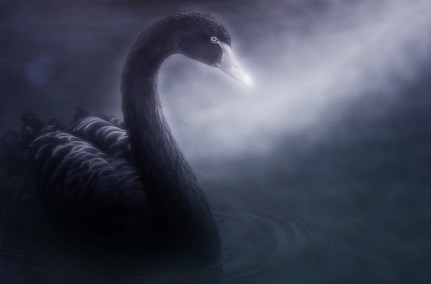

> The price exceeds 400 dollars on 12/19/2019, and goes up to around 800 afterwards.

> So, can we see signs of this rise before the 12/19/2019 ?

In [ ]:
# Import librairies
%matplotlib inline 
import matplotlib.pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams['lines.linewidth'] = 1

# Importing the data

In [ ]:
# Load the data
df = pd.read_csv("../input/tesla-stock-data-from-2010-to-2020/TSLA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.tail(10)

# First look at the shape and at the trend of the data (close & volume)

> Build a rolling windows of 20/100 days and plot the mean on this windows

In [ ]:
def plot_with_rolling(data,short_rolling,long_rolling,lbl='Close Price'):
    # Plot 
    fig, ax = plt.subplots(figsize=(20,9))

    ax.plot(data.index, data, label=lbl)
    ax.plot(short_rolling.index, short_rolling, label='20 days rolling')
    ax.plot(long_rolling.index, long_rolling, label='100 days rolling')
    ax.axvline(x='2019-12-19',linewidth=0.8, color='r')
    ax.axvline(x='2019-06-01',linewidth=0.8, color='g')
    ax.set_xlabel('Date')
    ax.set_ylabel(lbl)
    ax.legend()

    plt.show()

short = df.Close.rolling(window=20).mean()
long = df.Close.rolling(window=100).mean() 
plot_with_rolling(data=df.Close,short_rolling=short,long_rolling=long,lbl='Close Price')    
    
short = df.Close[df.index>'2018-12-21'].rolling(window=20).mean()
long = df.Close[df.index>'2018-12-21'].rolling(window=100).mean() 
plot_with_rolling(data=df.Close[df.index>'2018-12-21'],short_rolling=short,long_rolling=long,lbl='Close Price')

> <span>&#171;</span>The trend was really bullish since June, which is remarkable is perhaps the slope of the moving average 20 during the last months before our end point (2019-12-19)<span>&#187;</span>

> <span>&#171;</span>On the zoom, we see that the rise is very powerful after the beginning of september, the MA100 has absorded the decrease of the past and follow the MA20 <span>&#187;</span>

In [ ]:
short = df.Volume.rolling(window=20).mean()
long = df.Volume.rolling(window=100).mean()
plot_with_rolling(data=df.Volume,short_rolling=short,long_rolling=long,lbl='Volume')    
    
short = df.Volume[df.index>'2018-12-21'].rolling(window=20).mean()
long = df.Volume[df.index>'2018-12-21'].rolling(window=100).mean() 
plot_with_rolling(data=df.Volume[df.index>'2018-12-21'],short_rolling=short,long_rolling=long,lbl='Volume')


> <span>&#171;</span>Volume are not exceptionally high before our end point (2019-12-19),<br/> but volumes are constantly very high over the year 2019<span>&#187;</span>

# Calculate the daily returns

In [ ]:
# Calculate the daily return and the daily log return
daily_rtn = df.Close/df.Close.shift(1) - 1
daily_log_rtn = np.log(df.Close).diff()
# Calculate the daily return (another way)
# daily_rtn = close.pct_change(1)

daily_rtn.plot()
plt.show()
# log return


> <span>&#171;</span>Nothing to say ... <span>&#187;</span>

# The variance of the close and of the volume


In [ ]:
daily_rtn.rolling(30).var().plot()
plt.show()

> <span>&#171;</span>There is no spike of variance of the daily returns before the rise<span>&#187;</span>

In [ ]:
df['Volume'].rolling(50).var().plot()
plt.show()

> <span>&#171;</span>There is no spike of variance of the volumes before the rise<span>&#187;</span>

# Let's check classical indicator
# RSI14 - a trend oscillator

$$ RSI_{14} = 100 - (\frac{100}{1 + RS}) $$ 


$$ RS = Relative Strength = \frac{\text{average of all up moves in the last 14 days}}{\text{average of all down moves in the last 14 days}} = \frac{\text{AvgUP}}{\text{AvgDOWN}} $$

This leading indicator is limited from 0 to 100, when its value is below 30 it is said that it is overbought and when its value is above 70 it is said that it is overbought.

### How to calcul it ?
https://www.macroption.com/rsi-calculation/

https://www.investopedia.com/terms/r/rsi.asp

* Evaluate average_gain and average_loss for the first 14 days
* Caculate average_up and average_down with a recurrent formula

$$AvgUP(t) = \frac{UP(t) + 13 \times AvgUP(t-1)}{14}$$
$$AvgDOWN(t) = \frac{DOWN(t) + 13 \times AvgDOWN(t-1)}{14}$$

In [ ]:
# Calculate diff
diff=df.Close.diff().dropna()
# Ups
plus=diff.map(lambda x: x if x>0 else 0).rename('Plus')
# Downs
minus=diff.map(lambda x: -1*x if x<0 else 0).rename('Minus')

rsi14=pd.concat([diff,plus,minus],axis=1)
# init average up
rsi14['AvgUP'] = rsi14.Plus[:14].sum()/14
# init average down
rsi14['AvgDOWN'] = rsi14.Minus[:14].sum()/14

# calculate AvgUP and AvgDown with the recurrent formula
for i in range(14,rsi14.Close.size):
    rsi14['AvgUP'].iloc[i]=(rsi14['Plus'].iloc[i] + 13*rsi14['AvgUP'].iloc[i-1])/14
    rsi14['AvgDOWN'].iloc[i]=(rsi14['Minus'].iloc[i] + 13*rsi14['AvgDOWN'].iloc[i-1])/14

rsi14['RSI']=100 - 100 / (1+rsi14['AvgUP']/rsi14['AvgDOWN'])
rsi14.tail(10)

In [ ]:
short = rsi14['RSI'].rolling(window=20).mean()
long = rsi14['RSI'].rolling(window=100).mean()
plot_with_rolling(data=rsi14['RSI'],short_rolling=short,long_rolling=long,lbl='Close Price')    

# MACD (Moving Average Convergence-Divergence)
https://www.macroption.com/macd/

https://www.investopedia.com/terms/m/macd.asp

*EMA stands for "exponential moving average"*

* **MACD line = (shorter EMA of close prices) – (longer EMA of close prices)**
* **MACD Signal = EMA of MACD line**

With 

* s = period of the shorter EMA
* l = period of the longer EMA
* p = period of the EMA of MACD

These periods can be equal to (s=12, l=26, p=9) or (s=8, l=22, p=11), for instance


**How to interprete it ?**

| MACD line   | Description |
| ----------- | ----------- |
| positive and rising   | Market’s bullish momentum is accelerating        |
| negative and falling   | Market’s bearish momentum is accelerating        |
| positive but falling   | The bullish momentum in the market is fading        |
| negative but increasing   | The bearish momentum in the market is fading        |
| zero      | Balanced       |

In [ ]:
ema_short = df.Close.ewm(span=12, adjust=False).mean()
ema_long = df.Close.ewm(span=26, adjust=False).mean()
macd_line = ema_short - ema_long
macd_signal = macd_line.ewm(span=9, adjust=False).mean()


In [ ]:
# Plot 
fig, ax = plt.subplots(figsize=(20,9))

ax.plot(macd_line.index, macd_line, label='MACD Line')
ax.plot(macd_signal.index, macd_signal, label='MACD Signal')
ax.axvline(x='2019-12-19',linewidth=0.8, color='r')
ax.set_xlabel('Date')
ax.set_ylabel('MACD')
ax.legend()

plt.show()


# The momentum

https://www.macroption.com/momentum/


Momentum shows how much the closing price has changed, it indicates how much a trend is strong.

Momentum is the difference between current closing price and the closing price n days before

`Momentum = Close(Today) – Close(Today - n days)`

In [ ]:
momentum = df.Close.diff(20)
momentum.plot()
plt.show()

# Let's gather all this


In [ ]:

def plot_all(close=df.Close,rsi=rsi14['RSI'],macd=macd_line,momentum=momentum):
    fig = plt.figure(constrained_layout=True,figsize=(20,16))
    gs = fig.add_gridspec(10, 1)
    ax1 = fig.add_subplot(gs[:4, 0])
    ax1.set_title('Close')
    ax1.plot(close.index, close, label='Close')
    ax1.axvline(x='2019-12-19',linewidth=0.8, color='r')
    ax2 = fig.add_subplot(gs[4:6,0])
    ax2.set_title('RSI14')
    ax2.plot(rsi.index, rsi)
    ax2.axhline(y=30,linewidth=0.5, color='blue')
    ax2.axhline(y=70,linewidth=0.5, color='red')
    ax2.axvline(x='2019-12-19',linewidth=0.8, color='r')
    ax3 = fig.add_subplot(gs[6:8,0])
    ax3.set_title('MACD')    
    ax3.plot(macd.index, macd)
    ax3.axhline(y=0,linewidth=0.5, color='black')
    ax3.axvline(x='2019-12-19',linewidth=0.8, color='r')
    ax4 = fig.add_subplot(gs[8:,0])
    ax4.set_title('Momentum')
    ax4.plot(momentum.index, momentum)
    ax4.axhline(y=0,linewidth=0.5, color='black')
    ax4.axvline(x='2019-12-19',linewidth=0.8, color='r')
    plt.show()
plot_all()


# Zoom on the last year

In [ ]:
startd = '2018-12-31'
plot_all(close=df.Close[df.index>startd],rsi=rsi14['RSI'][rsi14.index>startd],macd=macd_line[macd_line.index>startd],momentum=momentum[momentum.index>startd])

> <span>&#171;</span>My comments ...<span>&#187;</span>

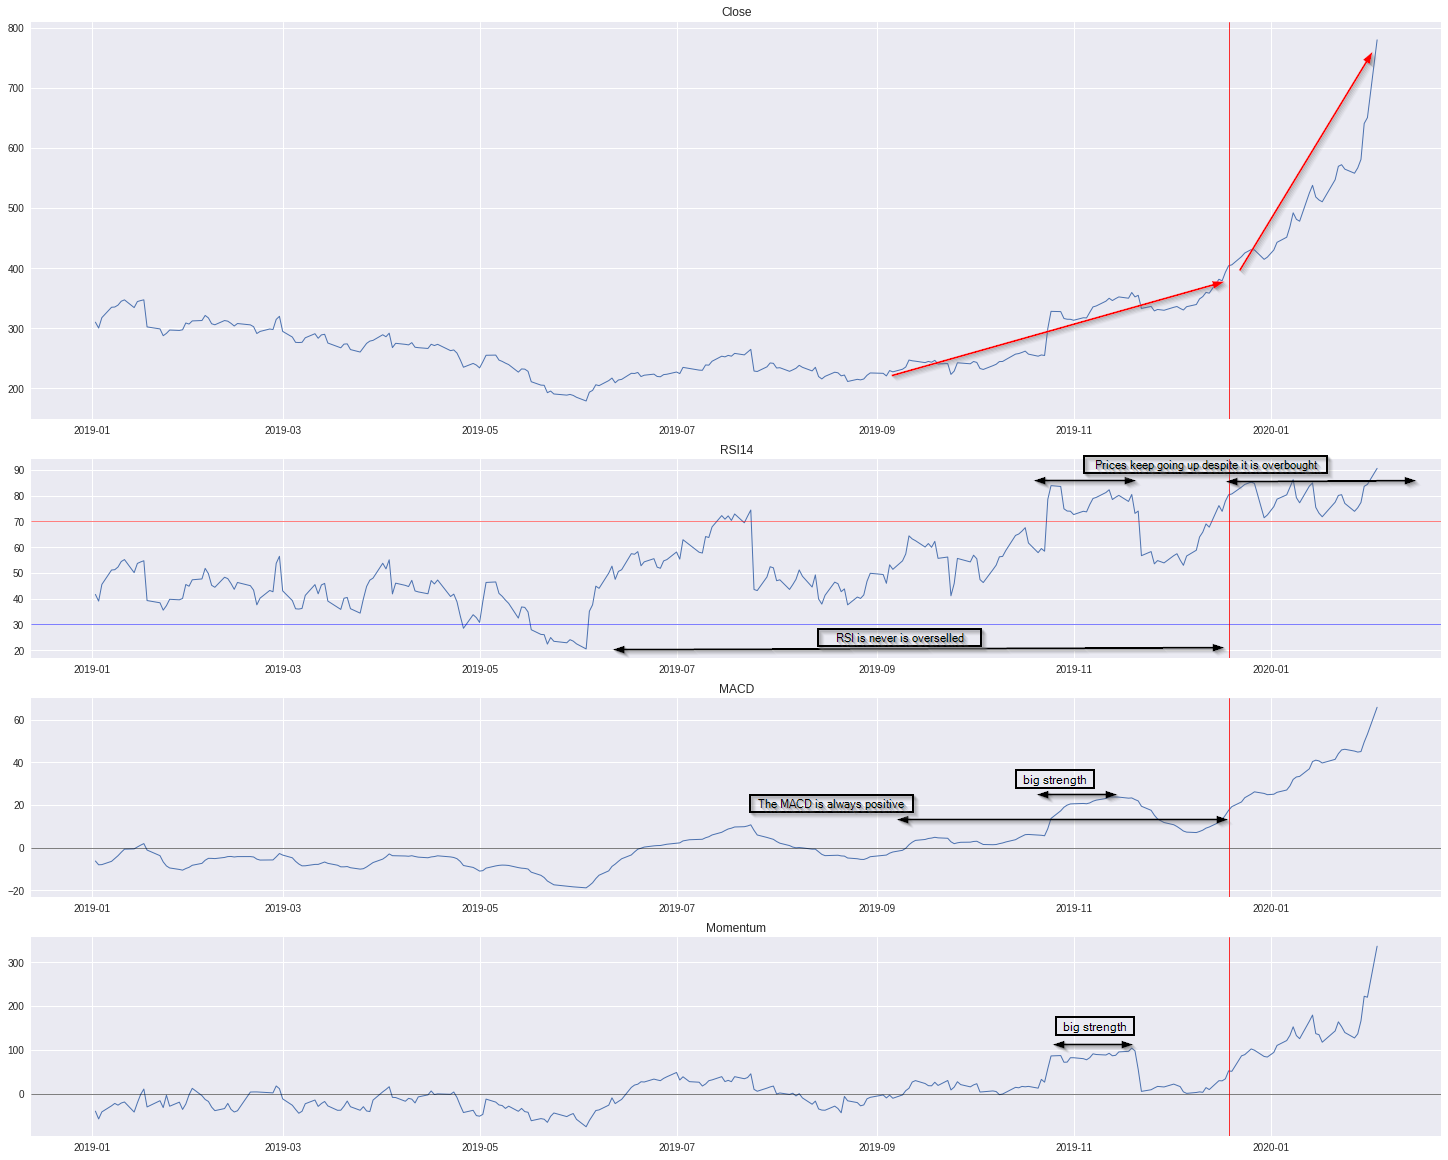

<div style="color: #004085;background-color: #cce5ff;border-color: #b8daff;">
  I'm not a trader, but if you like my try, please upvote
</div>